# Transform, explore and analyze a group chat on Whatsapp with NLP

Project Type: Data Cleaning, Visualisation and Data Analysis

In this project I use unstructured data from a group chat on WhatsApp. I show how to transform the unstructured data to structured data and provide different visualisations of the data through plots done with Plotly. Finally, I provide interesting insights about the users in this group.

0. First we need to install the new packages we will use in this project

In [2]:
#!pip install regex
#!pip install emoji
#!pip install plotly.express
#!pip install wordcloud
#!git clone https://github.com/amueller/word_cloud.git
#%cd word_cloud

In [3]:
#Checking the working directory
#import os
#os.getcwd()

In [4]:
#%cd ..

1.Loading the packages

Now we can import the packages to Jupyter 

In [5]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy import stats


2. Data Cleaning with REGEX 

In a text file, each line represents one comment, and I identify 4 tokens:
 <2019–10–19> <2:12:53 PM> <Peter Sagan> <La honte Fabio>
 <DATE> <TIME> <AUTHOR> <COMMENT>

In [6]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

Quick test to see if the function is working for this format

In [7]:
startsWithDateAndTime("[2020-04-20 6:46:53] Lance Amstrong: If there was a god, I'd still have both nuts.")

True

The function below will now identify the Authors of each message and then parse

In [8]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Last Name
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/laurentrisser/Desktop/dragons.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

2. Data Manipulation

The block below will be fixing the dates

In [9]:
#Quick look at the column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8492 non-null   datetime64[ns]
 1   Time     8492 non-null   object        
 2   Author   8472 non-null   object        
 3   Message  8492 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 265.5+ KB


In [10]:
#looking at the different Authors' names
df.Author.unique()

array(['Denis Weber', 'Gilles Jean Pierre', 'Fabien Cop',
       'Aurelien Pointereau', 'Rodrigue Voison', 'Didier Muckensturm',
       'Cyrille Millet Pfuch', 'Hervé Stratenmeyer', 'Laurent', 'Marc',
       'Eric Pally', 'Pierre', 'FX Laurent', 'Herv Dupont', None,
       'Hervé Dupont', 'Herv Stratenmeyer', 'Matthieu Liehn',
       'Alexandre Risser'], dtype=object)

In [11]:
#Replacing names with surnames
#df = df[df['Author'].apply(valid_user)]
df.loc[(df.Author == 'Denis Weber'), 'Author'] = 'Chris Froome'
df.loc[(df.Author == 'Gilles Jean Pierre'), 'Author'] = 'Egan Bernal' 
df.loc[(df.Author == 'Fabien Cop'), 'Author'] = 'Alberto Contador' 
df.loc[(df.Author == 'Aurelien Pointereau'), 'Author'] = 'Nairo Quintana' 
df.loc[(df.Author == 'Rodrigue Voison'), 'Author'] = 'Romain Bardet' 
df.loc[(df.Author == 'Didier Muckensturm'), 'Author'] = 'Vincenzo Nibali' 
df.loc[(df.Author == 'Cyrille Millet Pfuch'), 'Author'] = 'Peter Sagan' 
df.loc[(df.Author == 'Hervé Stratenmeyer'), 'Author'] = 'Emanuel Buchmann' 
df.loc[(df.Author == 'Laurent'), 'Author'] = 'Julian Alaphillipe' 
df.loc[(df.Author == 'Marc'), 'Author'] = 'Tony Gallopin' 
df.loc[(df.Author == 'Eric Pally'), 'Author'] = 'Thibaut Pinot' 
df.loc[(df.Author == 'Pierre'), 'Author'] = 'Tom Dumoulin' 
df.loc[(df.Author == 'FX Laurent'), 'Author'] = 'Fabio Aru' 
df.loc[(df.Author == 'Herv Dupont'), 'Author'] = 'Adam Yates' 
df.loc[(df.Author == 'Hervé Dupont'), 'Author'] = 'Adam Yates' 
df.loc[(df.Author == 'Herv Stratenmeyer'), 'Author'] = 'Warren Barguil' 
df.loc[(df.Author == 'Matthieu Liehn'), 'Author'] = 'Wout Van Aert' 
df.loc[(df.Author == 'Alexandre Risser'), 'Author'] = 'Bauke Mollema' 
#df = df[df['name'] != '<redacted>']
df['Author'].unique()


array(['Chris Froome', 'Egan Bernal', 'Alberto Contador',
       'Nairo Quintana', 'Romain Bardet', 'Vincenzo Nibali',
       'Peter Sagan', 'Emanuel Buchmann', 'Julian Alaphillipe',
       'Tony Gallopin', 'Thibaut Pinot', 'Tom Dumoulin', 'Fabio Aru',
       'Adam Yates', None, 'Warren Barguil', 'Wout Van Aert',
       'Bauke Mollema'], dtype=object)

In [12]:
#Dropping rows with NA value
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8472 entries, 0 to 8491
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8472 non-null   datetime64[ns]
 1   Time     8472 non-null   object        
 2   Author   8472 non-null   object        
 3   Message  8472 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 330.9+ KB


In [13]:
df.tail(5)

Date         Time              Author  \
8487 2020-08-24   7:52:13 AM    Emanuel Buchmann   
8488 2020-08-24   8:02:58 AM  Julian Alaphillipe   
8489 2020-08-24   8:05:35 AM        Chris Froome   
8490 2020-08-24   8:09:40 AM    Emanuel Buchmann   
8491 2020-08-24   8:22:58 AM        Chris Froome   

                                                Message  
8487  Oui ceux la aussi ils sont pénibles, je pense ...  
8488  Mais je pense que l'idée de Strava c'est de la...  
8489  Le nombre c pas gênant plus que ca, tant que c...  
8490  par ce que la personne fait le kom en ajoutant...  
8491  Par contre ça c des doublons pour moi et ceux ...

In [14]:
#Since we did not attach the media, once there is a media sent in the chat its creating the message 'image omitted'
#The script below is counting one media = +1 in the column media_messages
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print(media_messages)

727


In [15]:
#Create a new column emoji and report the type of emoji in the message
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text) 

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [16]:
#Number total of em0ji
emojis = sum(df['emoji'].str.len())
print(emojis)

2879


In [17]:
#Number total of messages
total_messages = df.shape[0]
print(total_messages)

8472


In [18]:
#Create a colum urlcount and count +1 once there is a link shared.
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [19]:
#Sum up the number of links shared on the group
links = np.sum(df.urlcount)

In [20]:
#Summary of the data
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 8472
Media: 727
Emojis: 2879
Links: 230


In [21]:
media_messages_df = df[(df['Message'] == 'image omitted')|(df['Message'] == 'video omitted')]

In [22]:
sticker_messages_df = df[df['Message'] == 'sticker omitted']
sticker_messages_df

Date          Time            Author          Message emoji  \
3121 2020-03-22    9:23:04 AM  Alberto Contador  sticker omitted    []   
3933 2020-04-11   10:23:06 AM    Nairo Quintana  sticker omitted    []   
8433 2020-08-23   12:07:37 PM    Nairo Quintana  sticker omitted    []   

      urlcount  
3121         0  
3933         0  
8433         0

In [23]:
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

In [24]:
#This block will create new columns and add it to the current the dataframe
#Create a new column Letter_count
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
#Create a new column Word_count
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
#Create a new column for 1 row = 1 
messages_df["MessageCount"]=1
#Create a new column emoji count
messages_df["emojicount"]= df['emoji'].str.len()
#Create a new column ratio number of words per emoji
messages_df["ratio_word_emoji"]= messages_df['Word_Count']/messages_df['emojicount']
#Replace infinite value by 0
messages_df["ratio_word_emoji"].replace(np.inf, 0, inplace=True)

In [25]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7709 entries, 0 to 8491
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7709 non-null   datetime64[ns]
 1   Time              7709 non-null   object        
 2   Author            7709 non-null   object        
 3   Message           7709 non-null   object        
 4   emoji             7709 non-null   object        
 5   urlcount          7709 non-null   int64         
 6   Letter_Count      7709 non-null   int64         
 7   Word_Count        7709 non-null   int64         
 8   MessageCount      7709 non-null   int64         
 9   emojicount        7709 non-null   int64         
 10  ratio_word_emoji  7709 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 722.7+ KB


In [26]:
messages_df.head(2)

Date         Time        Author  \
0 2019-10-15   1:38:00 PM  Chris Froome   
1 2019-10-15   1:38:44 PM   Egan Bernal   

                                             Message emoji  urlcount  \
0                       Jean pierre l'oeuil du Tigre    []         0   
1  Moi je me suis arrêté aux garage en vélo noir ...    []         0   

   Letter_Count  Word_Count  MessageCount  emojicount  ratio_word_emoji  
0            28           5             1           0               0.0  
1            50          11             1           0               0.0

In [27]:
#Exporting the dataframe into a csv file
messages_df.to_csv(r'/Users/laurentrisser/Desktop/data.csv', index = False)

4. Data Analysis

In [28]:
# Creates a list of unique Authors 
l = messages_df.Author.unique()

for i in range(len(l)):
    
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Statistics of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Total Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = round((np.sum(req_df['Word_Count']))/req_df.shape[0],2)
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Total Images/Video Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Total Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Total Links Sent', links)
  ratio = round((np.average(req_df['ratio_word_emoji'])),2)
  print('Average Emoji per message', ratio)
  print()

Statistics of Chris Froome -
Total Messages Sent 1207
Words per message 8.2
Total Images/Video Sent 51
Total Emojis Sent 361
Total Links Sent 9
Average Emoji per message 1.2

Statistics of Egan Bernal -
Total Messages Sent 1173
Words per message 10.15
Total Images/Video Sent 178
Total Emojis Sent 664
Total Links Sent 6
Average Emoji per message 1.62

Statistics of Alberto Contador -
Total Messages Sent 433
Words per message 7.17
Total Images/Video Sent 20
Total Emojis Sent 200
Total Links Sent 1
Average Emoji per message 2.96

Statistics of Nairo Quintana -
Total Messages Sent 928
Words per message 8.22
Total Images/Video Sent 118
Total Emojis Sent 261
Total Links Sent 118
Average Emoji per message 1.92

Statistics of Romain Bardet -
Total Messages Sent 199
Words per message 15.1
Total Images/Video Sent 16
Total Emojis Sent 65
Total Links Sent 16
Average Emoji per message 3.36

Statistics of Vincenzo Nibali -
Total Messages Sent 1478
Words per message 5.47
Total Images/Video Sent 102
T

In [29]:
#Checking the number of unique emoji
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

144


In [30]:
l = messages_df.Author.unique()

for i in range(len(l)):
    df_diversity = messages_df[messages_df['Author']== l[i]]
    print(f'Emoji Diversity of {l[i]}')
    list_diversity = list(set([a for b in df_diversity.emoji for a in b]))
    total_diversity = len(list_diversity)
    print(total_diversity)

Emoji Diversity of Chris Froome
29
Emoji Diversity of Egan Bernal
19
Emoji Diversity of Alberto Contador
44
Emoji Diversity of Nairo Quintana
40
Emoji Diversity of Romain Bardet
33
Emoji Diversity of Vincenzo Nibali
44
Emoji Diversity of Emanuel Buchmann
9
Emoji Diversity of Julian Alaphillipe
20
Emoji Diversity of Peter Sagan
25
Emoji Diversity of Tony Gallopin
21
Emoji Diversity of Thibaut Pinot
7
Emoji Diversity of Tom Dumoulin
7
Emoji Diversity of Fabio Aru
0
Emoji Diversity of Adam Yates
15
Emoji Diversity of Wout Van Aert
0
Emoji Diversity of Bauke Mollema
7


In [31]:
#List of all the emojis used with the count
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 834), ('😁', 294), ('😄', 213), ('👍🏻', 184), ('😉', 166), ('👍', 137), ('😜', 88), ('😅', 82), ('🤣', 76), ('🤔', 63), ('😀', 56), ('😱', 49), ('😝', 48), ('🤪', 33), ('😆', 32), ('😃', 29), ('🍾', 23), ('😊', 18), ('💪', 17), ('😭', 16), ('😎', 14), ('😡', 14), ('👌', 14), ('😍', 12), ('❄', 12), ('😩', 12), ('🙄', 10), ('🍺', 10), ('🍻', 10), ('☹️', 10), ('😢', 10), ('😯', 9), ('☃', 9), ('👍🏼', 9), ('🚴\u200d♂️', 9), ('😒', 8), ('😤', 8), ('😋', 7), ('🥂', 7), ('😓', 6), ('😙', 6), ('🙃', 6), ('😬', 6), ('🧐', 6), ('🚴', 6), ('😷', 5), ('🚲', 5), ('💶', 5), ('🏃🏽', 4), ('😛', 4), ('☺', 4), ('🍌', 4), ('🙂', 4), ('🤗', 4), ('🥵', 4), ('🤮', 4), ('🤫', 4), ('🥨', 4), ('🍷', 4), ('😳', 4), ('🤥', 3), ('😨', 3), ('☁️', 3), ('😰', 3), ('🤞', 3), ('⛄', 3), ('😘', 3), ('🤢', 3), ('🥳', 3), ('🤘', 3), ('🤓', 2), ('🤷🏻\u200d♂', 2), ('🤒', 2), ('😮', 2), ('⛷️', 2), ('💪🏻', 2), ('🌧', 2), ('🇨🇵', 2), ('🎁', 2), ('🎄', 2), ('😈', 2), ('🤨', 2), ('🙌', 2), ('🦵', 2), ('🐌', 2), ('😵', 2), ('🙈', 2), ('☔', 2), ('🏍', 2), ('👎', 2), ('🍕', 2), ('👨\u200d💻', 2), ('✌🏼', 2), 

In [32]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

In [33]:
emoji_df.sum()

emoji    😂😁😄👍🏻😉👍😜😅🤣🤔😀😱😝🤪😆😃🍾😊💪😭😎😡👌😍❄😩🙄🍺🍻☹️😢😯☃👍🏼🚴‍♂️😒😤😋🥂😓...
count                                                 2879
dtype: object

In [34]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label',title='Frequency of Emoji')
fig.show()

In [35]:
# Creates a list of unique Authors
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Chris Froome


Emoji Distribution for Egan Bernal


Emoji Distribution for Alberto Contador


Emoji Distribution for Nairo Quintana


Emoji Distribution for Romain Bardet


Emoji Distribution for Vincenzo Nibali


Emoji Distribution for Emanuel Buchmann


Emoji Distribution for Julian Alaphillipe


Emoji Distribution for Peter Sagan


Emoji Distribution for Tony Gallopin


Emoji Distribution for Thibaut Pinot


Emoji Distribution for Tom Dumoulin


Emoji Distribution for Fabio Aru


Emoji Distribution for Adam Yates


Emoji Distribution for Wout Van Aert


Emoji Distribution for Bauke Mollema


In [36]:
# Creates a list of unique Authors
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    total_emojis_list = list([a for b in dummy_df.emoji for a in b])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    print(total_emojis_list)

['😉', '😁', '😁', '😁', '😁', '😉', '😁', '😁', '☁️', '☁️', '☁️', '😁', '😁', '😁', '😉', '😁', '😁', '😁', '😉', '👍', '😁', '😉', '😁', '😉', '😁', '😉', '😁', '😉', '😉', '😁', '😉', '😁', '😃', '😁', '😁', '😁', '👍🏻', '😁', '🐒', '😉', '😉', '🌧', '🌧', '🇨🇵', '🇨🇵', '😀', '😀', '😀', '😀', '😀', '😀', '😉', '😉', '😀', '😀', '😉', '😀', '😀', '😀', '😀', '😀', '😀', '😃', '👍🏻', '👍🏻', '😀', '😀', '😉', '😉', '😀', '😀', '👍', '😀', '😉', '😀', '😀', '😀', '😉', '😀', '❄', '⛄', '⛄', '😉', '😉', '😉', '😉', '⛄', '❄', '👍', '😁', '😁', '😁', '👍', '😁', '😁', '😁', '😁', '👍', '😉', '😉', '😁', '🐌', '🐢', '😉', '😁', '😁', '😁', '😉', '😁', '😁', '😁', '😁', '😉', '👍🏻', '👍🏻', '😁', '😁', '😉', '😃', '😃', '😃', '😀', '😀', '👍🏻', '😀', '😉', '😉', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😉', '😀', '😁', '👍', '😀', '👍', '😉', '😁', '👍🏻', '👍', '👍', '👍', '👍', '👍', '😁', '😁', '🤔', '😎', '😎', '😉', '😉', '💶', '💶', '💶', '💶', '💶', '👍🏻', '👍🏻', '😉', '👍🏻', '😁', '😉', '😁', '😁', '😁', '😁', '👍🏻', '😁', '😁', '🤢', '🤮', '🤮', '😉', '😄', '😄', '😄', '😃', '😃', '👍🏻', '👍🏻', '👍🏻', '🤔', '😃', 

Text(0, 0.5, 'Date')

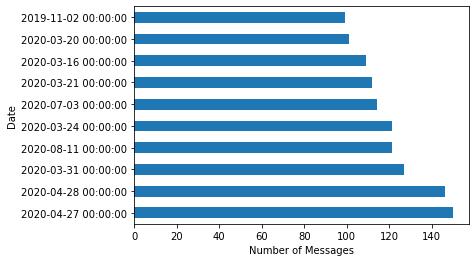

In [37]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [38]:
#Radar Plot for number of messages sent by day of the week

def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
        range=[0,1600]
    )),
  showlegend=False
)
fig.show()


In [39]:
#Radar Plot for number of emojis sent by day of the week
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df_emojicount =pd.DataFrame(messages_df["emojicount"])
day_df_emojicount['day_of_date'] = messages_df['Date'].dt.weekday
day_df_emojicount['day_of_date'] = day_df_emojicount["day_of_date"].apply(dayofweek)
day_df_emojicount["messagecount"] = 1
day = day_df_emojicount.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='emojicount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,700]
    )),
  showlegend=False
)
fig.show()

In [40]:
day_df_emojicount =pd.DataFrame(messages_df["emojicount"])
day_df_emojicount['day_of_date'] = messages_df['Date'].dt.weekday
day_df_emojicount['day_of_date'] = day_df_emojicount["day_of_date"].apply(dayofweek)
day_df_emojicount["messagecount"] = 1
day = day_df_emojicount.groupby("day_of_date").sum()
day.reset_index(inplace=True)
print(day)

  day_of_date  emojicount  messagecount
0      Friday         423          1514
1      Monday         324           877
2    Saturday         587          1407
3      Sunday         377           842
4    Thursday         313           791
5     Tuesday         502          1416
6   Wednesday         353           862


In [41]:
#Lets now calculate the average of messages per 
average_day = messages_df
average_day = average_day.drop(["Time","Author","Message","emoji","urlcount","Letter_Count","Word_Count","emojicount","ratio_word_emoji"], axis = 1)
print(average_day)

           Date  MessageCount
0    2019-10-15             1
1    2019-10-15             1
2    2019-10-15             1
3    2019-10-15             1
4    2019-10-15             1
...         ...           ...
8487 2020-08-24             1
8488 2020-08-24             1
8489 2020-08-24             1
8490 2020-08-24             1
8491 2020-08-24             1

[7709 rows x 2 columns]


In [42]:
df =  messages_df.groupby("Date").sum()
df.reset_index(inplace=True)




fig = go.Figure([
    go.Scatter(
        name='Message Count',
        x=df['Date'],
        y=df['MessageCount'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )
])
fig.update_layout(
    yaxis_title='Number of messages',
    title='Number of messages per day',
    xaxis_title = 'Time(Days)',
    hovermode="x"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [43]:
messages_df.head()

Date         Time            Author  \
0 2019-10-15   1:38:00 PM      Chris Froome   
1 2019-10-15   1:38:44 PM       Egan Bernal   
2 2019-10-15   1:38:54 PM      Chris Froome   
3 2019-10-15   1:40:20 PM  Alberto Contador   
4 2019-10-15   1:41:54 PM       Egan Bernal   

                                             Message      emoji  urlcount  \
0                       Jean pierre l'oeuil du Tigre         []         0   
1  Moi je me suis arrêté aux garage en vélo noir ...         []         0   
2        Pff il n'y a que fabien pour voir le ridley         []         0   
3      Non mais les p'tits culs je les ai vu aussi 🤓        [🤓]         0   
4  Sauf denis , trop préoccupé pour pas que l’on ...  [😎, 😎, 😎]         0   

   Letter_Count  Word_Count  MessageCount  emojicount  ratio_word_emoji  
0            28           5             1           0          0.000000  
1            50          11             1           0          0.000000  
2            43          10             1           0          0.000000  
3            45          11             1           1         11.000000  
4            69          14             1           3          4.666667

In [44]:
#Statistical difference before and after lockdown
#Lockdown in France 17 march 2020 – 11 may 2020
#We split the data set in 2 for pre and post lockdown
import pandas as pd
messages_df['Date'] = pd.to_datetime(messages_df['Date'])
messages_df = messages_df.set_index(messages_df['Date'])
messages_df = messages_df.sort_index()

pre_df = messages_df['2019-10-01':'2020-03-16']
post_df = messages_df['2020-03-17':'2020-08-24']

post_df = post_df.drop(["Time","Author","Message","emoji","urlcount","Letter_Count","Word_Count","emojicount","ratio_word_emoji"], axis = 1)
pre_df = pre_df.drop(["Time","Author","Message","emoji","urlcount","Letter_Count","Word_Count","emojicount","ratio_word_emoji"], axis = 1)
post_df.reset_index(drop=True, inplace=True)
pre_df.reset_index(drop=True, inplace=True)



pre_df.head()

Date  MessageCount
0 2019-10-15             1
1 2019-10-15             1
2 2019-10-15             1
3 2019-10-15             1
4 2019-10-15             1

In [45]:
#Groupby date
post_df = post_df.groupby("Date").sum()
pre_df = pre_df.groupby("Date").sum()

post_df.head()

MessageCount
Date                    
2020-03-17            90
2020-03-18            60
2020-03-19            89
2020-03-20           101
2020-03-21           112

In [46]:
print (pre_df.describe())

       MessageCount
count    109.000000
mean      20.944954
std       23.495797
min        1.000000
25%        5.000000
50%       13.000000
75%       27.000000
max      109.000000


In [47]:
print (post_df.describe())

       MessageCount
count    154.000000
mean      35.233766
std       31.882708
min        1.000000
25%       11.250000
50%       24.000000
75%       51.750000
max      150.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8e6f719d0>]],
      dtype=object)

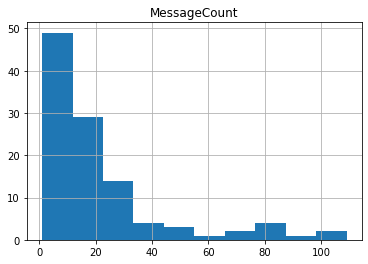

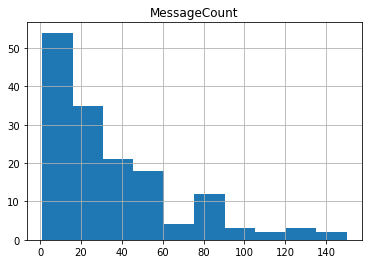

In [48]:
#Check normality
pre_df.hist()
post_df.hist()

No normal distribution = non parametric

In [49]:
#Plotting pre and post covid messages

y0 = pre_df['MessageCount']
y1 = post_df['MessageCount']

fig = go.Figure()
fig.add_trace(go.Box(y=y0,name='Pre COVID',
                marker_color = 'indianred'))
fig.add_trace(go.Box(y=y1, name = 'Post COVID',
                marker_color = 'lightseagreen'))

fig.show()

In [50]:
# Since the distribution is not parametric, I would need to use the Wilcoxon signed-rank test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy import stats

In [51]:
t, pvalue = stats.mannwhitneyu(pre_df,post_df, alternative=None)
print (t, pvalue)

5626.0 2.6310431684642433e-06


There is significant between pre and post Covid nunber of messages

In [70]:
#Number of messages through time group by day
messages_df.reset_index(drop=True, inplace=True)
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.show()

In [71]:
df.head()

Date  urlcount  Letter_Count  Word_Count  MessageCount  emojicount  \
0 2019-10-15         0           394          85            10           7   
1 2019-10-16         1           415          78            13           4   
2 2019-10-17         0           254          55             6           5   
3 2019-10-18         1           160          20             3           0   
4 2019-10-19         0          1733         361            65          11   

   ratio_word_emoji  
0             16.00  
1             27.00  
2             17.25  
3              0.00  
4             60.00

In [54]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")

fig.show()

In [55]:
#Groupby week
#date_df = messages_df.groupby([messages_df["Date"].dt.week]).sum()

messages_df['Week_Number'] = messages_df['Date'].dt.week
date_df = messages_df.groupby("Week_Number").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Week_Number", y="MessageCount")
fig.show()

In [56]:
date_df.tail(5)

Week_Number  urlcount  Letter_Count  Word_Count  MessageCount  emojicount  \
41           48         1          2526         501            78          30   
42           49         1          3067         628            78          40   
43           50         0           955         182            21           8   
44           51         2          1779         336            49          32   
45           52         6          9661        1934           260         131   

    ratio_word_emoji  
41         87.700000  
42        167.450000  
43         19.400000  
44        115.500000  
45        477.792857

In [57]:
messages_df.head()

Date         Time            Author  \
0 2019-10-15   1:38:00 PM      Chris Froome   
1 2019-10-15   1:38:44 PM       Egan Bernal   
2 2019-10-15   1:38:54 PM      Chris Froome   
3 2019-10-15   1:40:20 PM  Alberto Contador   
4 2019-10-15   1:41:54 PM       Egan Bernal   

                                             Message      emoji  urlcount  \
0                       Jean pierre l'oeuil du Tigre         []         0   
1  Moi je me suis arrêté aux garage en vélo noir ...         []         0   
2        Pff il n'y a que fabien pour voir le ridley         []         0   
3      Non mais les p'tits culs je les ai vu aussi 🤓        [🤓]         0   
4  Sauf denis , trop préoccupé pour pas que l’on ...  [😎, 😎, 😎]         0   

   Letter_Count  Word_Count  MessageCount  emojicount  ratio_word_emoji  \
0            28           5             1           0          0.000000   
1            50          11             1           0          0.000000   
2            43          10             1           0          0.000000   
3            45          11             1           1         11.000000   
4            69          14             1           3          4.666667   

   Week_Number  
0           42  
1           42  
2           42  
3           42  
4           42

In [58]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="Word_Count", color='Author', orientation="h",
             color_discrete_sequence=["red","orange","lime","teal","gold","olive","cyan","white","black","brown","purple", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Total Number of Words Sent per Author"
            )
fig.update_xaxes(title_text='Number of Words')
fig.update_yaxes(title_text='Author')

fig.show()

In [59]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red","orange","lime","teal","gold","olive","cyan","white","black","brown","purple", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Total Number of Messages Sent per Author"
            )
fig.update_xaxes(title_text='Number of Messages')
fig.update_yaxes(title_text='Author')
fig.show()

In [60]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="emojicount", color='Author', orientation="h", 
             color_discrete_sequence=["red","orange","lime","teal","gold","olive","cyan","white","black","brown","purple", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Total Number of Emojis Sent per Author"
            )
fig.update_xaxes(title_text='Number of Emoji')
fig.update_yaxes(title_text='Author')
fig.show()

In [61]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="urlcount", color='Author', orientation="h",
             color_discrete_sequence=["red","orange","lime","teal","gold","olive","cyan","white","black","brown","purple", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Total Number of URL Sent per Author"
            )
fig.update_xaxes(title_text='Number of URL')
fig.update_yaxes(title_text='Author')
fig.show()

In [62]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                              2020-01-02 00:00:00
Time                                                       5:10:57 PM
Author                                                   Tom Dumoulin
Message             Dis, papa, c’est quoi, un Alsacien? Ce n'est p...
emoji                                                              []
urlcount                                                            0
Letter_Count                                                     2426
Word_Count                                                        427
MessageCount                                                        1
emojicount                                                          0
ratio_word_emoji                                                    0
Week_Number                                                         1
Name: 1297, dtype: object

Text(0, 0.5, 'Frequency')

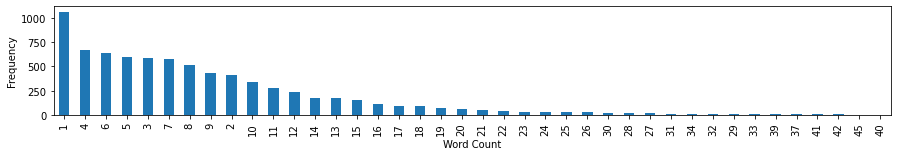

In [63]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

In [64]:
# Import packages
import numpy as np
from PIL import Image

In [65]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 342363 words in all the messages.


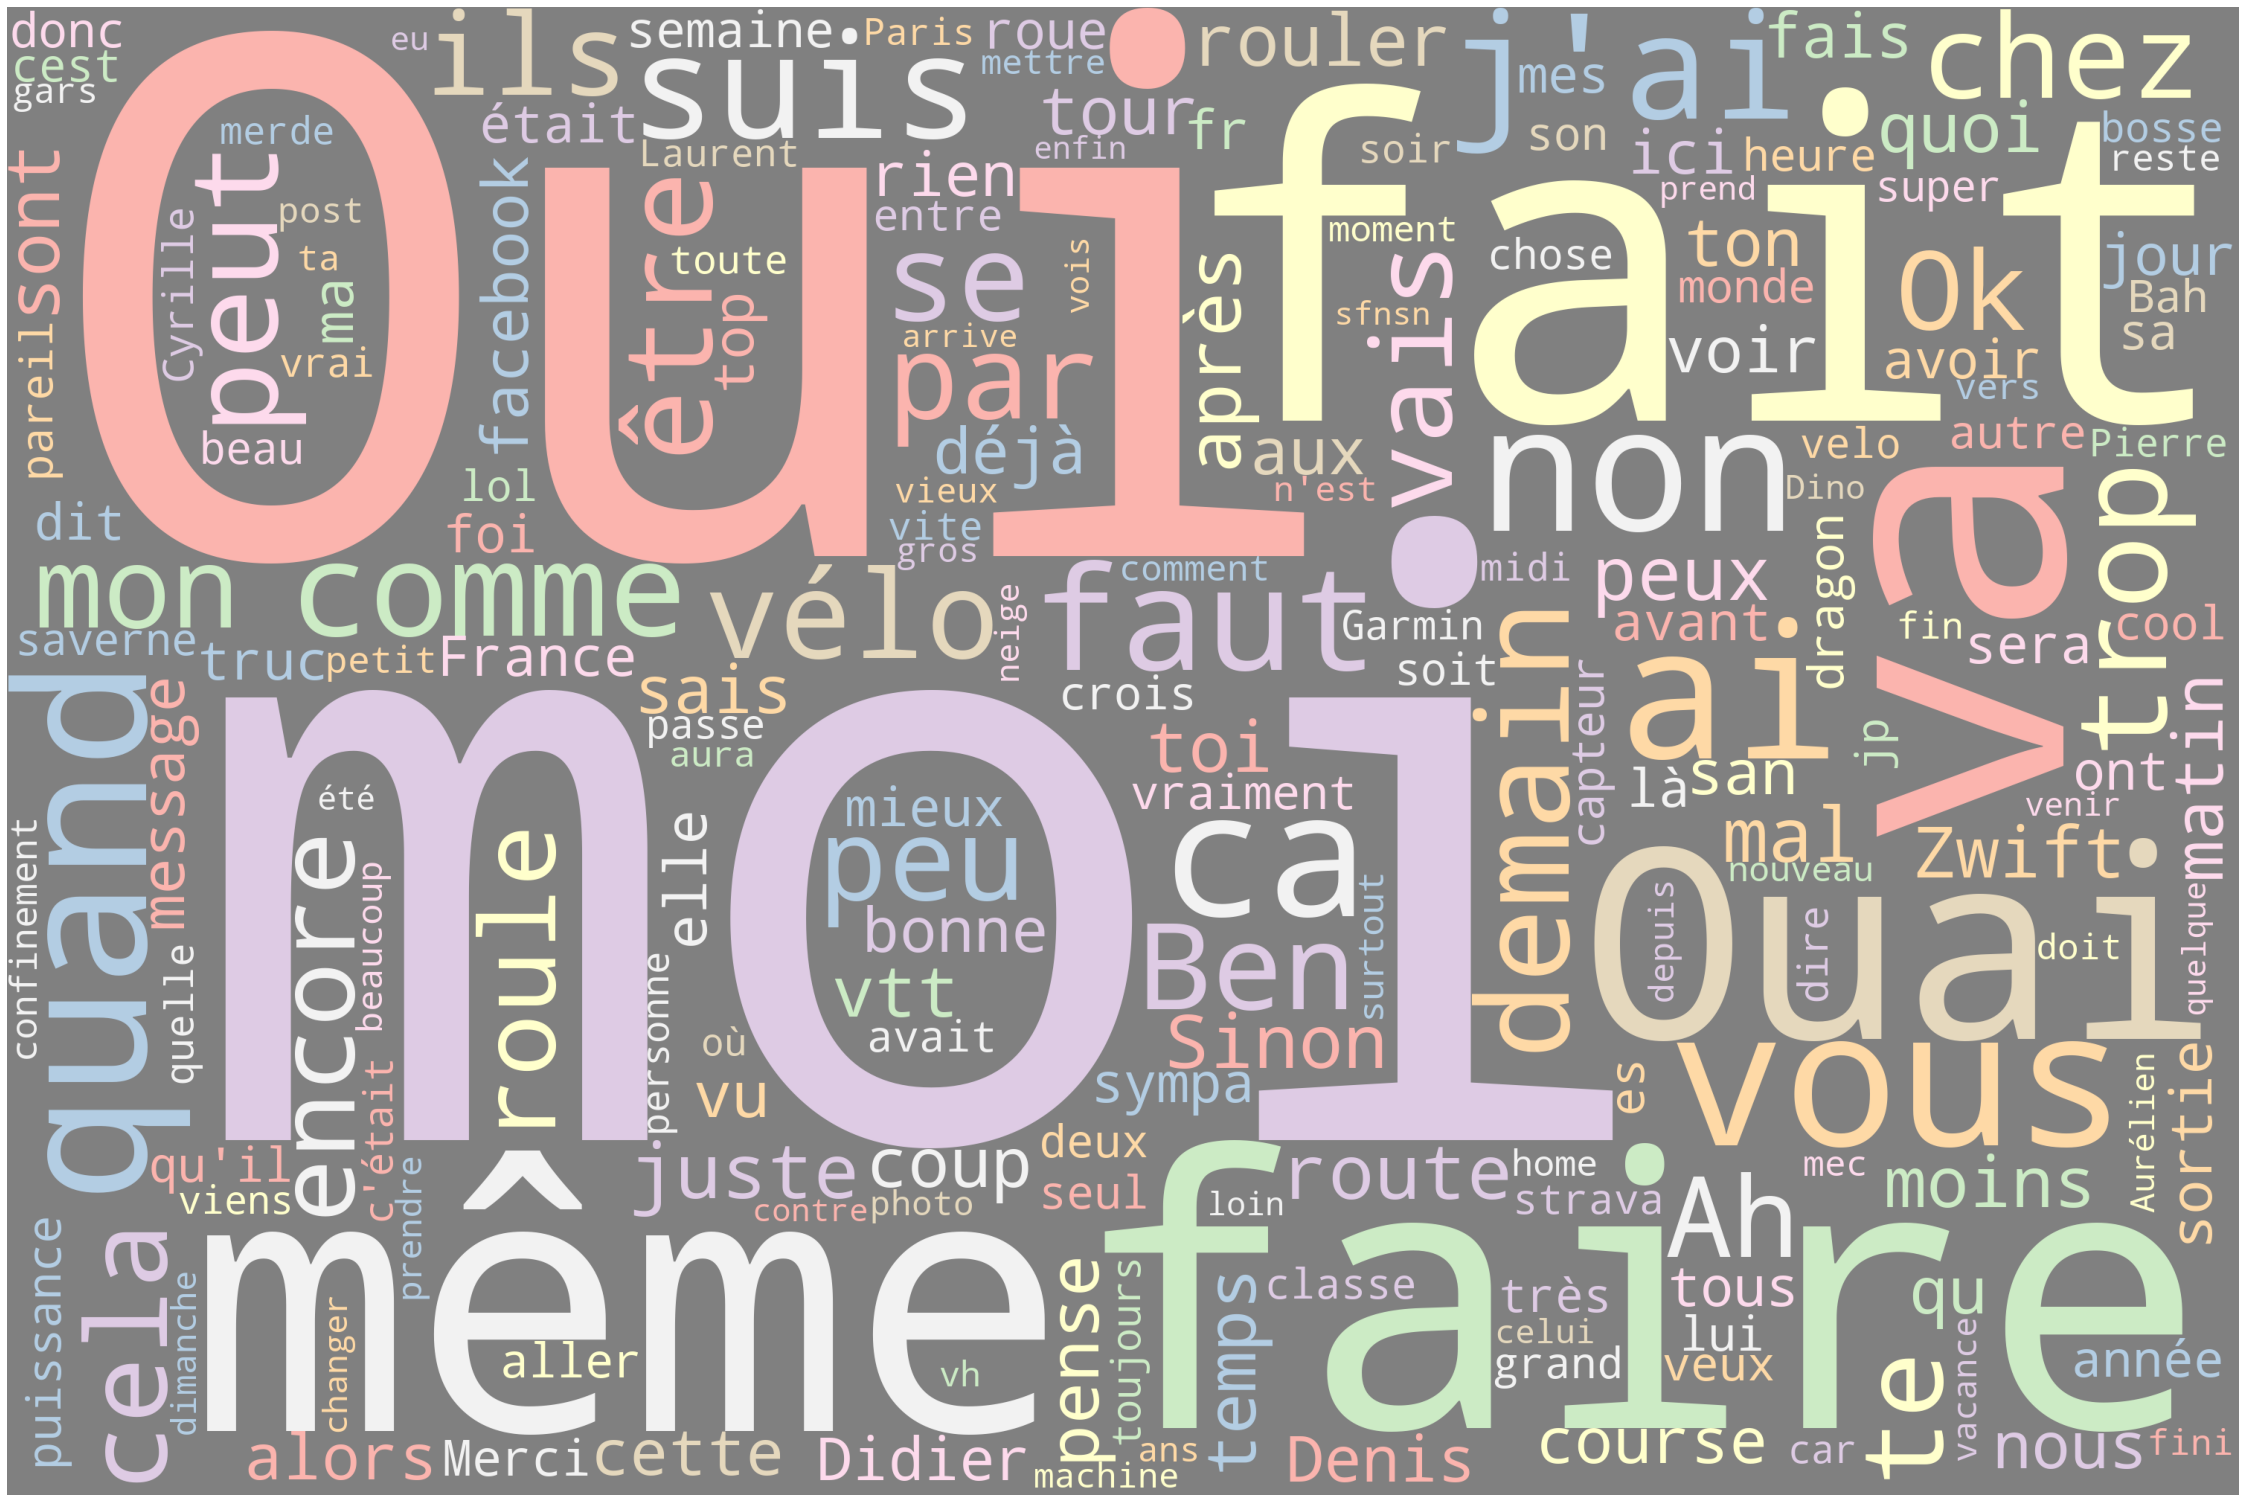

In [66]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
STOPWORDS.update(['ne','tout','au','qui','si','plu','plus','dans','dans','bien','bon','avec','video','deleted',"c'est",'image','omitted','le', 'la','de','en','je','tu','et','pa','un','des','aussi','ou','i','ça','les','il', 'pas','est','pour','que','c/est', 'sur', 'une', 'mai','du', 'mais','https','ce'])

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='grey', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

Vélo versus bière

In [67]:
# initializing the string and the word
word = "vélo"
## splitting the string at space
words = text.split()
## initializing count variable to 0
count = 0
## iterating over the list
for w in words:
   ## checking the match of the words
   if w == word:
      ## incrementint count on match
      count += 1
## printing the count
print(count)

115


In [68]:
# initializing the string and the word
word = "bière"
## splitting the string at space
words = text.split()
## initializing count variable to 0
count = 0
## iterating over the list
for w in words:
   ## checking the match of the words
   if w == word:
      ## incrementint count on match
      count += 1
## printing the count
print(count)

17


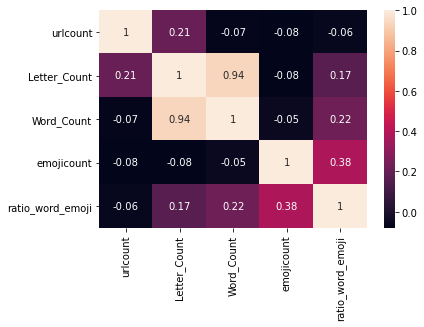

In [69]:
#Removing 2 columns from the dataframef
matrix_df = messages_df.drop(["MessageCount","Week_Number"], axis = 1)
corrMatrix = matrix_df.corr().round(decimals=2)
sns.heatmap(corrMatrix, annot=True)
plt.show()

# FUTURE WORK 

sentiment analysis

topic modeling and Naive Bayes for classification